In [1]:
import pandapower.networks as pn
import pandapower as pp
net = pn.create_cigre_network_mv(with_der=False)
net

This pandapower network includes the following parameter tables:
   - bus (15 elements)
   - load (18 elements)
   - switch (8 elements)
   - ext_grid (1 element)
   - line (15 elements)
   - trafo (2 elements)
   - bus_geodata (15 elements)

# STEP 2 : After the Charging Stations (CS) implementation and adding a load shape to the existent customers (time series simulation)

## 2.1 How’s the state of the network if compared with step 1 ? Better, worse, same as before...

In [2]:
#create 5 new buses
pp.create_bus(net, name='Bus CS1', vn_kv=0.4, type='b', geodata=((2,13))) 
pp.create_bus(net, name='Bus CS2', vn_kv=0.4, type='b', geodata=((1,9))) 
pp.create_bus(net, name='Bus CS3', vn_kv=0.4, type='b', geodata=((-1,3))) 
pp.create_bus(net, name='Bus CS4', vn_kv=0.4, type='b', geodata=((2,5))) 
pp.create_bus(net, name='Bus CS5', vn_kv=0.4, type='b', geodata=((12,5)))

#create transformer between those new bus and bus 2, 4, 6, 12, 14 (choose randomly) 
pp.create_transformer(net, hv_bus=2, lv_bus=pp.get_element_index(net, 'bus', 'Bus CS1'), name = 'CS1', std_type='0.63 MVA 20/0.4 kV')   #why did you choose this type of transfo ? 
pp.create_transformer(net, hv_bus=4, lv_bus=pp.get_element_index(net, 'bus', 'Bus CS2'), name = 'CS2', std_type='0.63 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=6, lv_bus=pp.get_element_index(net, 'bus', 'Bus CS3'), name = 'CS3', std_type='0.63 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=10, lv_bus=pp.get_element_index(net, 'bus', 'Bus CS4'), name = 'CS4', std_type='0.63 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=14, lv_bus=pp.get_element_index(net, 'bus', 'Bus CS5'), name = 'CS5', std_type='0.63 MVA 20/0.4 kV')

net

This pandapower network includes the following parameter tables:
   - bus (20 elements)
   - load (18 elements)
   - switch (8 elements)
   - ext_grid (1 element)
   - line (15 elements)
   - trafo (7 elements)
   - bus_geodata (20 elements)

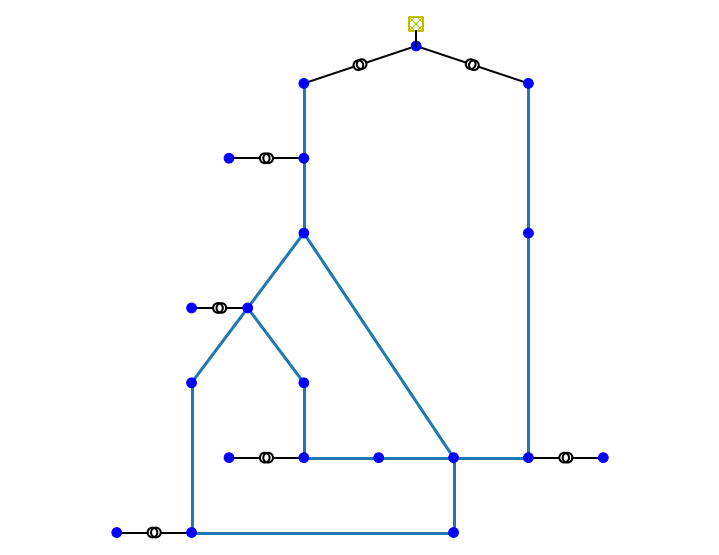

In [3]:
import pandapower.plotting as pplt
import matplotlib.pyplot as plt
ax = pplt.simple_plot(net, show_plot = False)
clc = pplt.create_line_collection(net,linewidth=3., use_bus_geodata= True)
pplt.draw_collections([clc],ax=ax)
plt.show()

In [4]:
import os
import numpy as np
import pandas as pd
import tempfile

from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl

load_shape = [0.28285, 0.272295, 0.2613828, 0.261328, 0.254316, 0.259789, 0.272966, 0.30915, 0.433979, 0.542955, 0.717333, 0.851829, 0.864118, 0.854116, 0.853815, 0.852508, 0.723452, 0.490362, 0.428271, 0.361402, 0.336596, 0.328176, 0.307331, 0.297966]


In [5]:
def create_data_source(n_timesteps=24):
    profiles = pd.DataFrame()
    for _, load in net.load.iterrows() :
        profiles['p_mw_'+str(load.name)] = [l * load.p_mw for l in load_shape]
        profiles['q_mvar_'+str(load.name)] = [l * load.q_mvar for l in load_shape]

    ds = DFData(profiles)
    return profiles, ds


In [6]:
def create_controllers(net, ds):
    ConstControl(net, element='load', variable='p_mw', element_index=[i for i, load in net.load.iterrows()], data_source=ds, profile_name=['p_mw_'+str(load.name) for i, load in net.load.iterrows()])
    ConstControl(net, element='load', variable='q_mvar', element_index=[i for i, load in net.load.iterrows()], data_source=ds, profile_name=['q_mvar_'+str(load.name) for i, load in net.load.iterrows()])


In [7]:
def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".xlsx", log_variables=list())
    # these variables are saved to the harddisk after / during the time series loop
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_load', 'q_mvar')
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    return ow

In [8]:
def timeseries_example(output_dir):
    # 1. create test net
    # net = simple_test_net()
    # 2. create (random) data source
    n_timesteps = len(load_shape)
    profiles, ds = create_data_source(n_timesteps)
    # 3. create controllers (to control P values of the load and the sgen)
    create_controllers(net, ds)

    # time steps to be calculated. Could also be a list with non-consecutive time steps
    time_steps = range(0, n_timesteps)

    # 4. the output writer with the desired results to be stored to files.
    ow = create_output_writer(net, time_steps, output_dir=output_dir)

    # 5. the main time series function
    run_timeseries(net, time_steps)

In [9]:
output_dir = os.path.join("time_series")
print("Results can be found in your local folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
timeseries_example(output_dir)


  0%|          | 0/24 [00:00<?, ?it/s]

Results can be found in your local folder: time_series


 88%|████████▊ | 21/24 [00:02<00:01,  1.52it/s]

In step 1, the loadshape was 100% anytime, now in step 2 it's always lower, so sate of network is better
But no load on the charging stations yet